In [1]:
%matplotlib notebook

import os
import yaml
import sys
import datetime
import numpy as np
import json
import keras.backend as K
import tensorflow as tf

from matplotlib import pyplot as plt

# NeMO-Net specific files 
sys.path.append("./utils/") # Adds higher directory to python modules path.
from NeMO_CoralData import CoralData
from NeMO_models import AlexNetLike, SharpMask_FCN
from NeMO_generator import NeMOImageGenerator, ImageSetLoader
from NeMO_backend import get_model_memory_usage
from NeMO_losses import charbonnierLoss, keras_lovasz_softmax, categorical_focal_loss
import NeMO_layers
from keras.models import Model, Sequential, load_model
from keras.callbacks import (
    ReduceLROnPlateau,
    CSVLogger,
    EarlyStopping,
    ModelCheckpoint,
    TerminateOnNaN)
from NeMO_callbacks import CheckNumericsOps, WeightsSaver
from NeMO_Generator import NeMOImageGenerator
from NeMO_DirectoryIterator import NeMODirectoryIterator

import tensorflow as tf
from tensorflow.python.client import device_lib
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

num_cores = 4
num_GPU = 1
num_CPU = 1

global _SESSION
config = tf.ConfigProto(intra_op_parallelism_threads=num_cores,
        inter_op_parallelism_threads=num_cores, allow_soft_placement=True,
        device_count = {'CPU' : num_CPU, 'GPU' : num_GPU})
_SESSION = tf.Session(config=config)
K.set_session(_SESSION)

%matplotlib notebook

Using TensorFlow backend.
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
CoralClasses_config = './config/CoralClasses.json'
with open(CoralClasses_config) as json_file:
    CoralClasses = json.load(json_file)
labelkey = CoralClasses["VedConsolidated_ClassDict"]

DataSource_config = "./config/RefineNet_DataSource.yaml" # Training files info
with open(DataSource_config, 'r') as stream:
    try:	
        init_args = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)

train_loader = ImageSetLoader(**init_args['image_set_loader']['train'])
val_loader = ImageSetLoader(**init_args['image_set_loader']['val'])
y = train_loader.image_size[1]
x = train_loader.image_size[0]
num_channels = 4


# imgpath = '/home/shared/NeMO-Net Data/KSLOF-CICIA-FIJI/Cicia_Satellite_image_mosaic_KSLOF.tif'
# labelpath = '/home/shared/NeMO-Net Data/KSLOF-CICIA-FIJI/Cicia_habitats_watt_KSLOF.shp'

imgpath = '/home/shared/NeMO-Net Data/processed_Fiji_files/mosaiced_003.TIF'
labelpath = '/home/shared/NeMO-Net Data/KSLOF-CICIA-FIJI/Cicia_Habitat_classes_raster_KSLOF.tif'

Fiji = CoralData(imagepath = imgpath, labelpath = labelpath, labelkey = CoralClasses["Fiji_ClassDict"], load_type = "raster", shpfile_classname = 'Hab_name')
Fiji.consolidate_classes(newclassdict = CoralClasses["L3_ClassDict"], transferdict = CoralClasses["Fiji2L3_Dict"])
Fiji.consolidate_classes(newclassdict = CoralClasses["VedConsolidated_ClassDict"], transferdict = CoralClasses["L32VedConsolidated_Dict"])

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Row: 0 completed
Row: 128 completed
Row: 256 completed


<IPython.core.display.Javascript object>


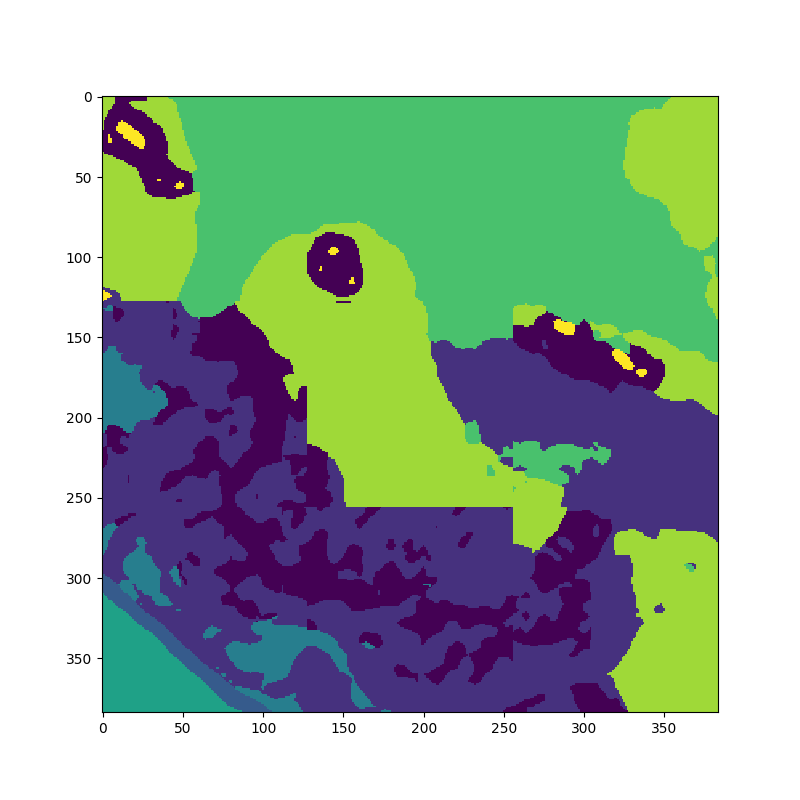

In [3]:
model = load_model('./tmp/RefineMask_Jarrett256_RGB_NIR_spectralshift.h5', custom_objects={'BilinearUpSampling2D':NeMO_layers.BilinearUpSampling2D, 'charbonnierLoss': charbonnierLoss})

ystart = 1186-256
xstart = 4105-256
ylen = 512
xlen = 512
image_array = Fiji.image[ystart: ystart+ylen, xstart:xstart+xlen, :]
image_array = np.delete(image_array, [0,3,5,7], 2)
num_classes = len(CoralClasses["VedConsolidated_ClassDict"])

final_predict = Fiji.predict_on_whole_image(model = model, 
    image_array = image_array,
    num_classes = num_classes,
    image_mean = 100.0,
    image_std = 100.0, 
    patch_size = 256,
    num_lines = None, 
    spacing = (128, 128), 
    predict_size = 128)


fig = plt.figure(1,figsize=(8,8))
ax = plt.subplot(111)
ax.imshow(final_predict)
plt.show()
